In [1]:
import os
from utils.configuration import *
from sklearn.model_selection import train_test_split

In [2]:
experiment_name = "api_ordinal_simple_4"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

In [3]:
setup_configuration(experiment_name,EXPERIMENT_DIR)

Created new configuration file at /home/bule/TramDag/dev_experiment_logs/api_ordinal_simple_4/configuration.json


In [4]:
# import numpy as np
# import pandas as pd
# from sklearn.datasets import make_classification

# # Generate synthetic data for logistic regression
# X, y = make_classification(
#     n_samples=100_000,      # number of samples
#     n_features=1,       # one predictor
#     n_informative=1,    # the predictor is informative
#     n_redundant=0,      # no redundant features
#     n_clusters_per_class=3,
#     class_sep=1.5,      # separation between classes
#     weights=[0.9, 0.1],  # 90% class 0, 10% class 1
#     random_state=42
# )

# # Convert to DataFrame for convenience
# df = pd.DataFrame({'x': X.flatten(), 'y': y})

# # Save or inspect
# print(df.head())


import numpy as np
import pandas as pd

# Generate one continuous predictor
n = 100_000
x = np.random.normal(0, 1, n)

# Define thresholds for 4 ordered levels
thresholds = [-0.8, 0.0, 0.8]

# Digitize x into 4 ordinal levels (0,1,2,3)
y = np.digitize(x, thresholds)

# Combine into DataFrame
df = pd.DataFrame({'x': x, 'y': y})

print(df.head())
print(df['y'].value_counts(normalize=True))


          x  y
0  0.408253  2
1 -0.507555  1
2  0.854164  3
3  0.085160  2
4 -0.813474  0
y
1    0.28848
2    0.28835
3    0.21297
0    0.21020
Name: proportion, dtype: float64


In [5]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [6]:
data_type={'x':'continous','y':'ordinal_Xn_Yo'}
data_type

{'x': 'continous', 'y': 'ordinal_Xn_Yo'}

In [7]:
write_data_type_to_configuration(data_type, CONF_DICT_PATH)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x                    | continous       | continuous [c]                 | continuous [c]                
y                    | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
---------------------------------------------------------------------------------------------------------
Configuration updated successfully.


In [8]:
interactive_adj_matrix(CONF_DICT_PATH,seed=19)

No matrix found. Please fill out the DAG and click 'Generate'.


In [10]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [11]:
from utils.tramdag import TramDagConfig , TramDagModel

cfg = TramDagConfig.load(f"/home/bule/TramDag/dev_experiment_logs/{experiment_name}/configuration.json")
cfg.compute_levels(train_df)
device='cpu'

[WARNING] levels are missing for some ordinal variables in configuration dict. THIS will FAIL in model training later!
 Please provide levels manually to config and reload or compute levels from data using the method compute_levels().
 e.g. cfg.compute_levels(train_df) # computes levels from training data and writes to cfg


In [12]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=True,device=device,initial_data = train_df) 
# 1m52s

[DEBUG] TramDagModel using device: cpu

[INFO] Building model for node 'x' with settings: {'set_initial_weights': False, 'debug': True, 'verbose': True, 'device': 'cpu', 'initial_data':               x  y
75220 -1.089829  0
48955  1.259470  3
44966 -0.385528  1
13568  0.304039  2
92727 -1.735785  0
...         ... ..
6265   0.764173  2
54886  0.983609  3
76820 -0.292881  1
860    1.245446  3
15795  0.418154  2

[80000 rows x 2 columns]}
[DEBUG] get_fully_specified_tram_model(): device: cpu
[DEBUG] default_number_thetas for continuous outcomes: 20

[INFO] Building model for node 'y' with settings: {'set_initial_weights': False, 'debug': True, 'verbose': True, 'device': 'cpu', 'initial_data':               x  y
75220 -1.089829  0
48955  1.259470  3
44966 -0.385528  1
13568  0.304039  2
92727 -1.735785  0
...         ... ..
6265   0.764173  2
54886  0.983609  3
76820 -0.292881  1
860    1.245446  3
15795  0.418154  2

[80000 rows x 2 columns]}
[DEBUG] get_fully_specified_tram_model(): dev

In [14]:
td_model.fit(train_df, val_df,
            #  train_list=['target'],
             learning_rate=1e-2,
             epochs=400,batch_size=1_000,
             verbose=True,debug=False,
             device=device,
             save_linear_shifts=True,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

#30 eps 1m 49s seq mode from start 1000 bs
#30 eps 2m 27s parllel multiprocessing mode from start 1000 bs
# 200 eps 9m 30s seq mode from start 1000 bs

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/api_ordinal_simple_4/min_max_scaling.json
[INFO] Training 2 nodes (sequential) on cpu

[INFO] Training node 'x' for 400 epochs on cpu (pid=657587)
[INFO] Existing model found. Loading weights and history...

[INFO] Training node 'y' for 400 epochs on cpu (pid=657587)
[INFO] No existing model found. Starting fresh...

===== Epoch 1/400 =====


[INFO] Saved linear shift weights for epoch 1 -> /home/bule/TramDag/dev_experiment_logs/api_ordinal_simple_4/y/linear_shifts_all_epochs.json
[INFO] Saved new best model.
[INFO] Epoch 1: Train NLL=1.4652 | Val NLL=1.2085 | Time=1.14s

===== Epoch 2/400 =====
[INFO] Saved linear shift weights for epoch 2 -> /home/bule/TramDag/dev_experiment_logs/api_ordinal_simple_4/y/linear_shifts_all_epochs.json
[INFO] Saved new best model.
[INFO] Epoch 2: Train NLL=1.0648 | Val NLL=0.9321 | Time=0.52s

===== Epoch 3/400 =====
[INFO] Saved linear shift weights for epoch 3 -> /home/bule/TramDag/dev_experiment_logs/api_ordinal_simple_4/y/linear_shifts_all_epochs.json
[INFO] Saved new best model.
[INFO] Epoch 3: Train NLL=0.8450 | Val NLL=0.7607 | Time=0.54s

===== Epoch 4/400 =====
[INFO] Saved linear shift weights for epoch 4 -> /home/bule/TramDag/dev_experiment_logs/api_ordinal_simple_4/y/linear_shifts_all_epochs.json
[INFO] Saved new best model.
[INFO] Epoch 4: Train NLL=0.7044 | Val NLL=0.6473 | Time

KeyboardInterrupt: 

In [15]:
rsamples, latents = td_model.sample()

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Deleting all previously sampled data.
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_simple_4/x/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_simple_4/y/sampling

----*----------*-------------*--------Sample Node: x ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x from standard logistic distribution
[WARNING] target_col 'x' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 43.60it/s]

[INFO] Completed sampling for node 'x'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node y from standard logistic distribution
[WARNING] target_col 'y' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


[INFO] Loaded training/validation histories for 2 nodes.


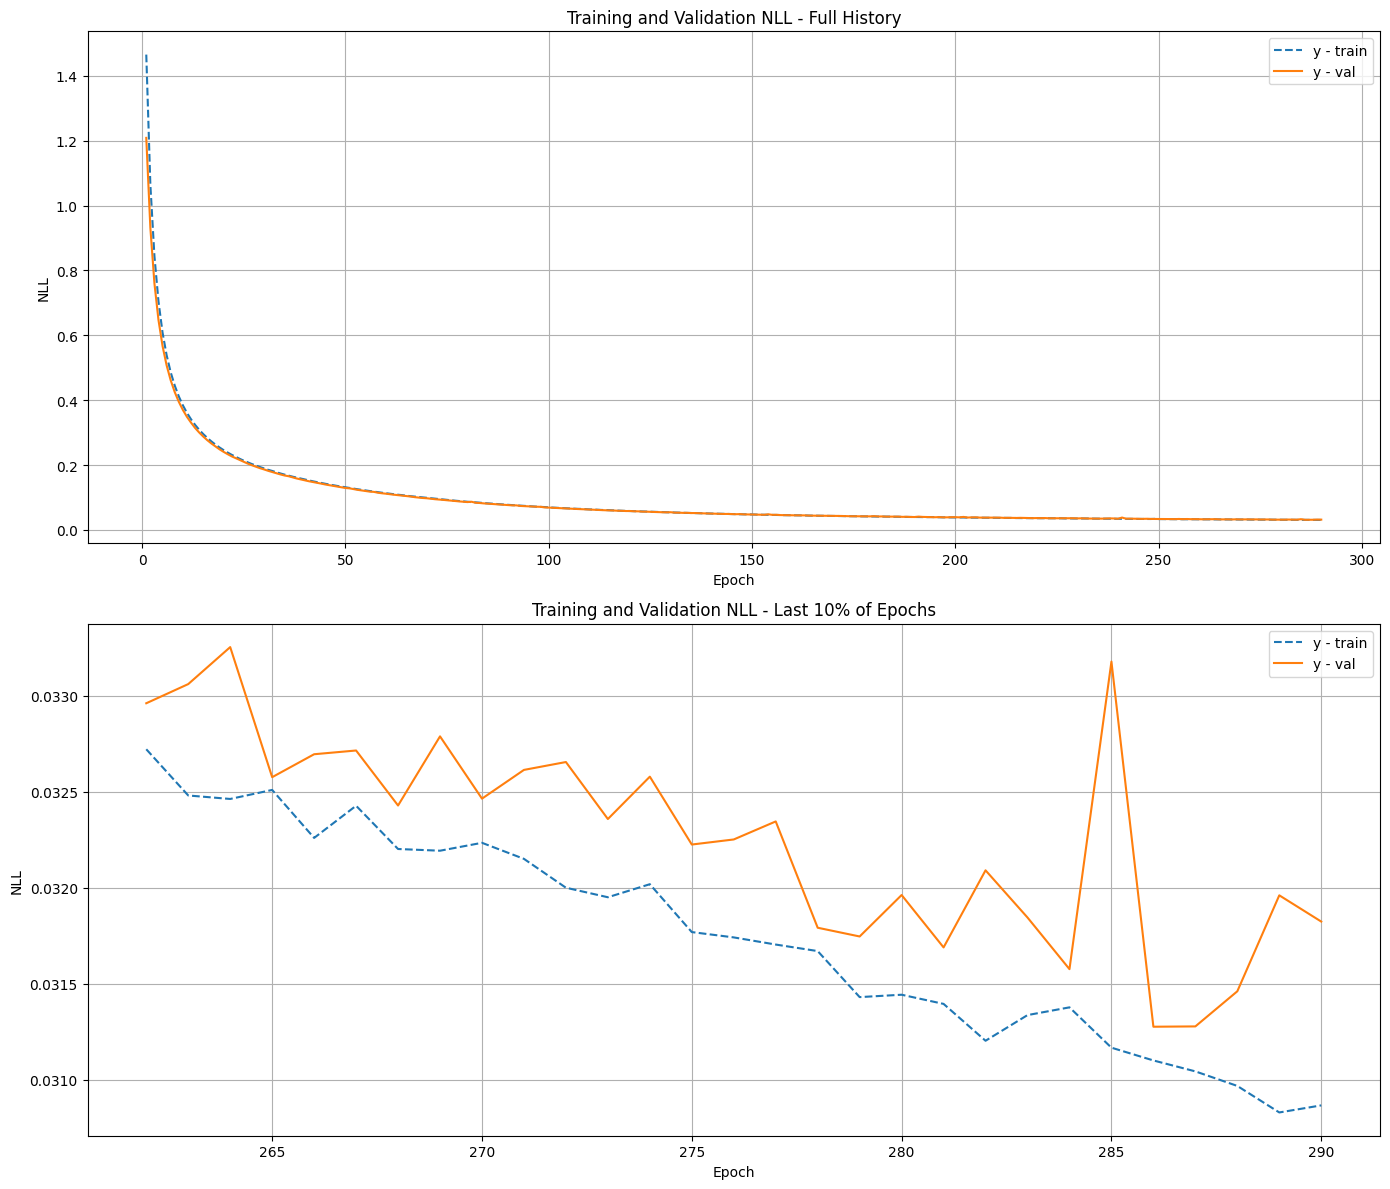

In [16]:
td_model.plot_history('y')

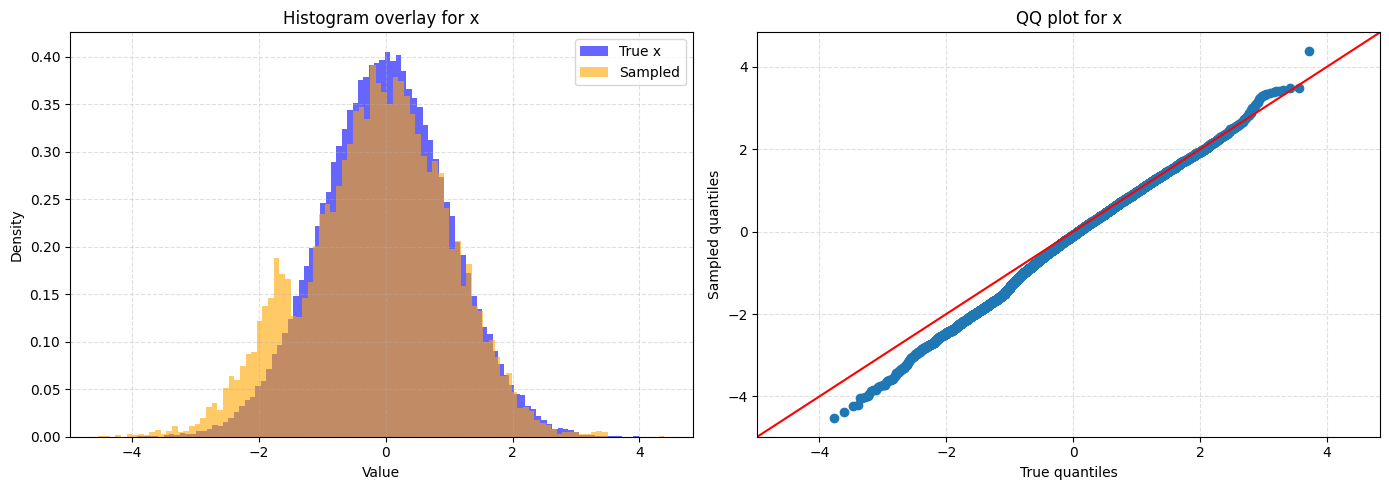

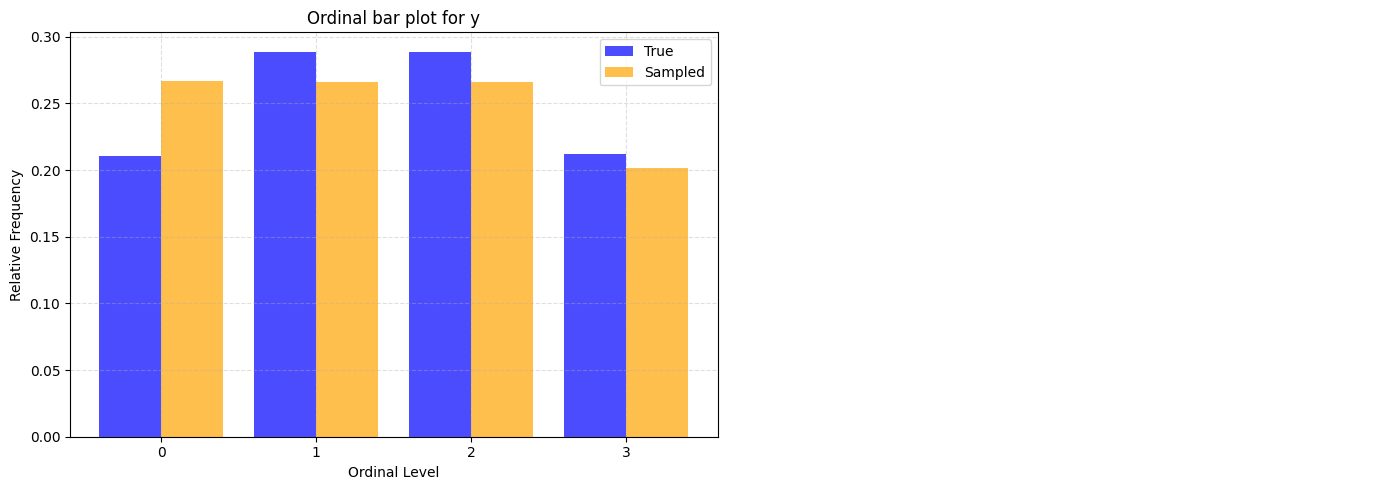

In [17]:
td_model.show_samples_vs_true(train_df)
# TODO add funciootn to print out shioft terms for each model and SI coefficients 

In [ ]:
linear_shift=td_model.linear_shift_history()

[WARNING] No linear shift history found for node 'x' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_simple_3/x/linear_shifts_all_epochs.json


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_shift_histories(data_dict,node):
    """
    Plot the evolution of shift terms across epochs for a given node (e.g., 'target').

    Args:
        data_dict (dict): Dictionary where keys are node names (e.g., 'target')
                          and values are DataFrames with epochs as columns and shifts as rows.
        node (str): Node name to plot (default='target')
    """
    df = data_dict[node].copy()

    # Flatten nested lists in DataFrame cells
    df = df.applymap(lambda x: x[0][0] if isinstance(x, list) and isinstance(x[0], list) else x)

    # Convert column names to integers if possible
    df.columns = [int(c.replace('epoch_', '')) if isinstance(c, str) and c.startswith('epoch_') else c for c in df.columns]

    # Sort by epoch
    df = df.reindex(sorted(df.columns), axis=1)

    # Plot each shift
    plt.figure(figsize=(10, 6))
    for shift in df.index:
        plt.plot(df.columns, df.loc[shift], label=shift)

    plt.xlabel('Epoch')
    plt.ylabel('Shift value')
    plt.title(f'Shift term history for node: {node}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_656483/346125792.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x[0][0] if isinstance(x, list) and isinstance(x[0], list) else x)


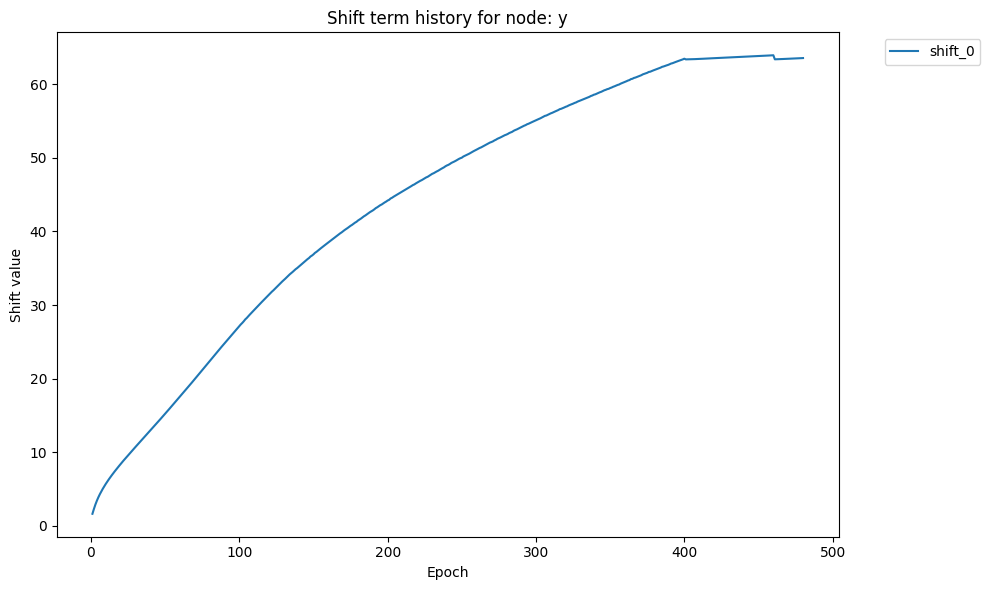

In [ ]:
plot_shift_histories(linear_shift,node='y')
